# Nb-20180307-2015-TickerPlot

Refactor ticker plot from previous notebook entry. This is based on https://matplotlib.org/1.5.1/examples/pylab_examples/finance_work2.html

- Make it a function
- Use finance.py functions
- Make RSI and MACD plots optional
- Allow overlays

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

In [3]:
import finance as fat

In [4]:
# Change the plot size.
plt.rcParams['figure.figsize'] = [18.0, 10.0]

In [5]:
def relative_strength(prices, n=14):
    """
    compute the n period relative strength indicator
    http://stockcharts.com/school/doku.php?id=chart_school:glossary_r#relativestrengthindex
    http://www.investopedia.com/terms/r/rsi.asp
    """

    deltas = np.diff(prices)
    seed = deltas[:n+1]
    up = seed[seed >= 0].sum()/n
    down = -seed[seed < 0].sum()/n
    rs = up/down
    rsi = np.zeros_like(prices)
    rsi[:n] = 100. - 100./(1. + rs)

    for i in range(n, len(prices)):
        delta = deltas[i - 1]  # cause the diff is 1 shorter

        if delta > 0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta

        up = (up*(n - 1) + upval)/n
        down = (down*(n - 1) + downval)/n

        rs = up/down
        rsi[i] = 100. - 100./(1. + rs)

    return rsi

In [6]:
def format_macd_axis(axis, df_macd) :
    # compute the MACD indicator
    fillcolor = 'darkslategrey'
    textsize = 9
    
    date = df_macd.index
    macd = df_macd['MACD']
    signal = df_macd['Signal']
    hist = df_macd['Histogram']
    
    axis.plot(date, macd, color='black', lw=1, alpha=0.3)
    axis.plot(date, signal, color='blue', lw=1, alpha=0.3)
    axis.fill_between(date, hist, 0, alpha=0.5, facecolor=fillcolor, edgecolor=fillcolor)

    axis.text(0.025, 0.95, 'MACD', va='top', transform=axis.transAxes, fontsize=textsize)
    #axis.set_xlim(date[0], date[-1])

In [7]:
def format_rsi_axis(axis, df_rsi) :
    textsize = 9
    fillcolor = 'darkgoldenrod'
    date = df_rsi.index
    rsi = df_rsi['RSI']

    axis.plot(date, rsi, color=fillcolor)
    axis.axhline(70, color='red', alpha=0.3)
    axis.axhline(30, color='green', alpha=0.3)
    axis.fill_between(date, rsi, 70, where=(rsi >= 70), facecolor='red', edgecolor='red', alpha=0.3)
    axis.fill_between(date, rsi, 30, where=(rsi <= 30), facecolor='green', edgecolor='green', alpha=0.3)
    axis.text(0.6, 0.9, '>70 = overbought', va='top', transform=axis.transAxes, fontsize=textsize)
    axis.text(0.6, 0.1, '<30 = oversold', transform=axis.transAxes, fontsize=textsize)
    axis.set_ylim(0, 100)
    axis.set_yticks([30, 70])
    axis.text(0.025, 0.95, 'RSI (14)', va='top', transform=axis.transAxes, fontsize=textsize)
    #axis.set_xlim(date[0], date[-1])

In [8]:
def format_volume_axis(axis, ohlcv_df) :
    r = ohlcv_df
    fillcolor = 'darkgoldenrod'
    volume = (r['Close']*r['Volume'])/1e6  # dollar volume in millions
    vmax = volume.max()
    date = ohlcv_df.index
    
    axis.fill_between(date, volume, 0, label='Volume', facecolor=fillcolor, edgecolor=fillcolor, alpha=0.1)
    axis.set_ylim(0, 1.05*vmax)
    axis.set_yticks([])

In [9]:
def get_plot_ohlcv_summary_str(ohlcv_df) :
    first = ohlcv_df.iloc[0]
    last = ohlcv_df.iloc[-1]
    
    start_date = ohlcv_df.index[0]
    end_date = ohlcv_df.index[-1]
    date_format_str = '%d-%b-%Y'
    op = first['Open']
    cl = last['Close']
    high = ohlcv_df['High'].max()
    low = ohlcv_df['Low'].min()
    volume = ohlcv_df['Volume'].sum()
    
    s = '%s to %s: O:%1.2f H:%1.2f L:%1.2f C:%1.2f, V:%1.1fM Chg:%+1.2f%%' % (
        start_date.strftime(date_format_str), end_date.strftime(date_format_str),
        op, high, low, cl, volume*1e-6, cl - op)
    return s

In [10]:
def format_ohlc_axis(axis, ohlc_df, overlays_df) :
    # convenience vars
    date = ohlc_df.index
    low = ohlc_df['Low']
    high = ohlc_df['High']
    op = ohlc_df['Open']
    cl = ohlc_df['Close']
    
    # get days that were up
    up = cl >= op

    # Adjust width of candlestick appropriately
    # FIXME: this is currently a hack based on typical plot size
    if (len(ohlc_df) < 100) :
        width = 5
        alpha = 1.0
    elif (len(ohlc_df) < 150) :
        width = 3
        alpha = 1.0
    else :
        width = 1
        alpha = 0.4
        
    # high and low
    axis.vlines(date[up], low[up], high[up], color='green', label='_nolegend_', alpha=alpha)
    axis.vlines(date[~up], low[~up], high[~up], color='red', label='_nolegend_', alpha=alpha)
    # open and close
    axis.vlines(date[up], op[up], cl[up], color='green', label='_nolegend_', linewidths=width)
    axis.vlines(date[~up], op[~up], cl[~up], color='red', label='_nolegend_', linewidths=width)

    axis.plot(date, cl, color='black', label='Close', alpha=0.3)
    
    # Plot overlays
    if overlays_df is not None:
        overlays_df.plot(ax=axis)
        
    #min_val = overlays_df.min_val
    #max_val = overlays_df.max_val
    
    #axis.set_ylim(min_val, max_val)

In [11]:
def plot_daily_ticker(ohlcv_df, macd_df=None, rsi_df=None, overlays_df=None) :
    """
    """
    # Get start and end dates for date axis, pad for plotting
    start_date = ohlcv_df.index[0] - dt.timedelta(0.5)
    end_date = ohlcv_df.index[-1] + dt.timedelta(0.5)
    date = ohlcv_df.index
    label_axis = None
    no_label_axes = []
    
    plt.rc('axes', grid=True)
    plt.rc('grid', color='0.75', linestyle='-', linewidth=0.5)

    fig = plt.figure(facecolor='white')
    axescolor = '#f6f6f6'  # the axes background color
    textsize = 9
    left, width = 0.1, 0.8
  
    rect_rsi = [left, 0.7, width, 0.1]
    rect_ohlcv = [left, 0.1, width, 0.6]
    rect_macd = [left, 0.0, width, 0.1]

    ax_rsi = None
    
    # RSI
    if rsi_df is not None :
        ax_rsi = fig.add_axes(rect_rsi, facecolor=axescolor)  # left, bottom, width, height
        rsi = rsi_df[start_date:end_date]
        format_rsi_axis(ax_rsi, rsi)
        no_label_axes.append(ax_rsi)
        ax_rsi.set_title(f'{ticker}')

    # OHLC
    ax_ohlc = fig.add_axes(rect_ohlcv, facecolor=axescolor, sharex=ax_rsi)
    format_ohlc_axis(ax_ohlc, ohlcv_df, overlays_df[start_date:end_date])
    if rsi_df is None :
        ax_ohlc.set_title(f'{ticker}')

    # Volume
    ax_vol = ax_ohlc.twinx()
    format_volume_axis(ax_vol, ohlcv_df)
    no_label_axes.append(ax_vol)

    # ... summary string 
    s = get_plot_ohlcv_summary_str(ohlcv_df)
    t4 = ax_ohlc.text(0.3, 0.95, s, transform=ax_ohlc.transAxes, fontsize=textsize+1)

    # ... legend
    props = font_manager.FontProperties(size=10)
    leg = ax_ohlc.legend(loc='best', prop=props) #, shadow=True, fancybox=True)
    leg.get_frame().set_alpha(0.5)

    # MACD
    ax_macd = None
    if macd_df is not None :
        ax_macd = fig.add_axes(rect_macd, facecolor=axescolor, sharex=ax_ohlc)
        macd = macd_df[start_date:end_date]
        format_macd_axis(ax_macd, macd)
        no_label_axes.append(ax_ohlc)
        label_axis = ax_macd
    else :
        label_axis = ax_ohlc
    
    # turn off upper axis tick labels
    for ax in no_label_axes :
        for label in ax.get_xticklabels():
            label.set_visible(False)

    # rotate the lower ones, etc
    for label in label_axis.get_xticklabels():
        label.set_rotation(30)
        label.set_horizontalalignment('right')
    label_axis.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')

    # set start and end date for all axes
    all_axes = list(no_label_axes)
    all_axes.append(label_axis)
    for ax in all_axes :
        ax.set_xlim(start_date, end_date)
    
    class MyLocator(mticker.MaxNLocator):
        def __init__(self, *args, **kwargs):
            mticker.MaxNLocator.__init__(self, *args, **kwargs)

        def __call__(self, *args, **kwargs):
            return mticker.MaxNLocator.__call__(self, *args, **kwargs)

    # at most 5 ticks, pruning the upper and lower so they don't overlap
    # with other ticks
    ax_ohlc.yaxis.set_major_locator(mticker.MaxNLocator(5, prune='both'))
    if (ax_macd) :
        ax_macd.yaxis.set_major_locator(mticker.MaxNLocator(5, prune='both'))

    ax_ohlc.yaxis.set_major_locator(MyLocator(5, prune='both'))
    if (ax_macd) :
        ax_macd.yaxis.set_major_locator(MyLocator(5, prune='both'))

    plt.show()

In [12]:
ticker = 'TLT'
df = fat.create_price_data(ticker)

Loaded data for TLT: 2002-07-30 to 2018-03-07.


In [13]:
df['RSI'] = relative_strength(df['Close'])

In [14]:
df_rsi = pd.DataFrame(df['RSI'])

In [15]:
df_macd = fat.create_macd_df(df, 'Close')

In [16]:
sma_df = fat.create_sma_df(df, 'Close', [20,200])
del sma_df['Close']
sma_df.tail()

,Close SMA20,Close SMA200
Date,,
2018-03-01,118.634499,124.65765
2018-03-02,118.516999,124.64185
2018-03-05,118.439499,124.61560
2018-03-06,118.310999,124.58920
2018-03-07,118.213499,124.56070


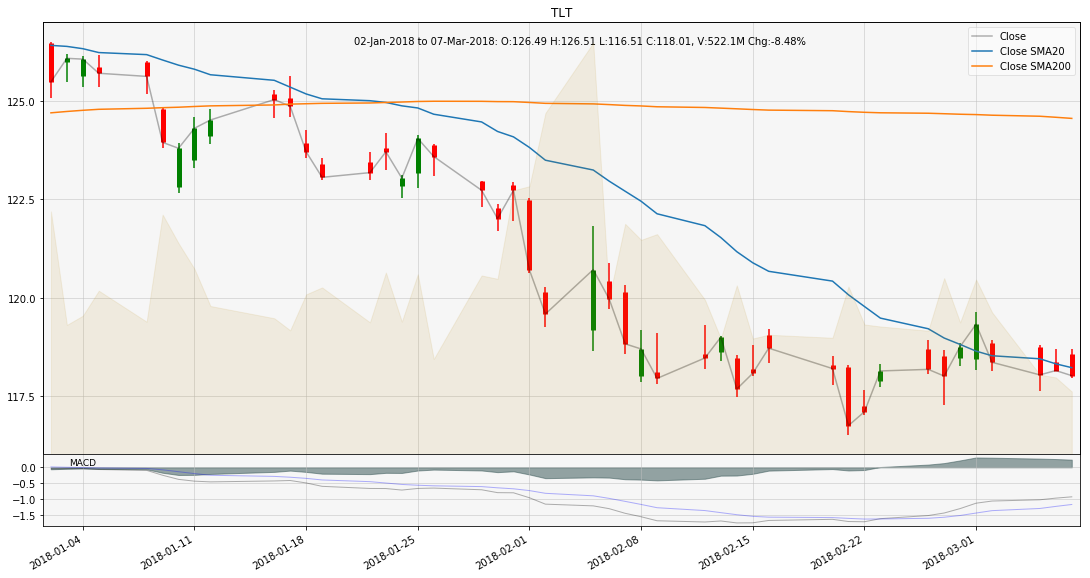

In [17]:
#df = df['2017-03-07':'2018-02-01']
plot_df = df['2018-01-01':'2018-03-07']
#plot_daily_ticker(df, macd_df=df_macd, rsi_df=df_rsi)
plot_daily_ticker(plot_df, macd_df=df_macd, overlays_df=sma_df)
#plot_daily_ticker(df)